# I. Imports

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from random import *

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

from sklearn.metrics import f1_score
from cv2 import resize

In [2]:
import utils.helpers.constants as path
from utils.helpers.data import * 
from utils.helpers.plot import * 
from utils.helpers.video import * 

# II. Récupération des données

### a. Création d'un dossier d'image de validation (executer une fois)

In [9]:
# __validation_proportion__ = 0.2

In [7]:
# for dirname in os.listdir(__train_path__) : 
#     print(f"Il y a {len(os.listdir(__train_path__+dirname))} images dans {dirname}")

Il y a 1019 images dans Bowl
Il y a 874 images dans CanOfCocaCola
Il y a 1024 images dans MilkBottle
Il y a 1032 images dans Rice
Il y a 787 images dans Sugar


In [6]:
# __validation_path__ = os.path.join(__original_dataset_path__, 'validation/')
# os.mkdir(__validation_path__)

In [10]:
# for classe in os.listdir(__train_path__) : 
#     classe_path =  os.path.join(__validation_path__, classe+'/')
#     os.mkdir(classe_path)
#     len_validation = int(len(os.listdir(__train_path__+classe))*__validation_proportion__)
#     src_path = __train_path__+classe+'/'
#     dst_path = classe_path

#     for _ in range(len_validation) : 
#         rdm_filename = choice(os.listdir(__train_path__+classe+'/'))
#         src_path_complete = src_path + rdm_filename
#         dst_path_complete = dst_path + rdm_filename
#         shutil.copyfile(src_path_complete, dst_path_complete)
#         os.remove(src_path_complete)

### b. DataSets

In [2]:
train_img, train_labels, val_img, val_labels, test_img, test_labels = get_datasets()
class_labels, __nb_classes__ = get_labels()

Train:		Found 3792 images belonging to 5 classes.
Validation:	Found 944 images belonging to 5 classes.
Test:		Found 3568 images belonging to 5 classes.


### c. Visualisation des données

In [3]:
print(val_labels)
print("*"*25)
print(train_labels)
print("*"*25)
print(test_labels)

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
*************************
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]
*************************
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [7]:
i = randint(0, len(val_img))
filename = val_img.filepaths[i]
path = filename.split("\\")[0]
    
filename = filename.split("\\")[1]

img = cv2.imread(os.path.join(path,filename))
print(img[0][0])
print(img.shape)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img_rgb[0][0])
print(img_rgb.shape)

img_resize = resize(img_rgb, (227,227))
print(img_resize.shape)

preprocess_img = preprocess_input(img_resize)
print(preprocess_img.shape)


[27 41 61]
(227, 227, 3)
[61 41 27]
(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


[ 59 112 170]
[24 25 35]
[ 60  85 131]


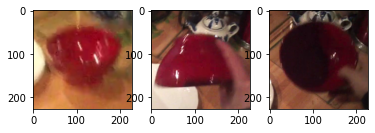

In [8]:
def show_rdm_img(directory):
    i = randint(0, len(directory))
    filename = directory.filepaths[i]
    path = filename.split("\\")[0]

    filename = filename.split("\\")[1]

    img = cv2.imread(os.path.join(path, filename))
    print(img[0][0])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(131)
show_rdm_img(train_img)
plt.subplot(132)
show_rdm_img(val_img)
plt.subplot(133)
show_rdm_img(test_img)

In [9]:
test_img.__getitem__(0)

(array([[[[ -69.939    ,  -86.779    ,  -97.68     ],
          [ -71.939    ,  -88.779    ,  -99.68     ],
          [ -69.939    ,  -89.779    ,  -99.68     ],
          ...,
          [ -45.939003 ,  -63.779    ,  -78.68     ],
          [ -49.939003 ,  -67.779    ,  -82.68     ],
          [ -47.939003 ,  -65.779    ,  -80.68     ]],
 
         [[ -70.939    ,  -88.779    ,  -96.68     ],
          [ -72.939    ,  -89.779    , -100.68     ],
          [ -71.939    ,  -91.779    , -101.68     ],
          ...,
          [ -44.939003 ,  -62.779    ,  -77.68     ],
          [ -45.939003 ,  -65.779    ,  -80.68     ],
          [ -46.939003 ,  -64.779    ,  -79.68     ]],
 
         [[ -72.939    ,  -90.779    ,  -98.68     ],
          [ -73.939    ,  -91.779    ,  -99.68     ],
          [ -71.939    ,  -92.779    ,  -99.68     ],
          ...,
          [ -42.939003 ,  -62.779    ,  -77.68     ],
          [ -45.939003 ,  -65.779    ,  -80.68     ],
          [ -46.939003 ,  -67.7

In [10]:
test_img.__len__()

112

# III. Modèle de classification

In [19]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

__learning_rate__ = 1e-5
__epochs__ = 50
__x_shape__ = (227,227,3)

### a. Modele VGG

In [116]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, mode='max', min_lr=__learning_rate__)
filepath="models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor= 'val_accuracy', mode= 'max', save_best_only = True, verbose= 1)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=__x_shape__)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### b. Finetuning

In [66]:
for layer in base_model.layers[:15]:
	layer.trainable = False
	
x = base_model.output
x = Flatten()(x) 
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(__nb_classes__, activation='softmax')(x)

final_model= Model(inputs=base_model.input, outputs=x)
final_model.summary()

opt = Adam(learning_rate=__learning_rate__)
final_model.compile(loss="categorical_crossentropy", optimizer = opt, metrics=["accuracy"])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [67]:
history = final_model.fit(train_img, validation_data=val_img, epochs=__epochs__, callbacks=[lr_reduce, early_stopping, checkpoint])

Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 2.9152 - accuracy: 0.5786
Epoch 00001: val_accuracy improved from -inf to 0.93114, saving model to models\weights-improvement-01-0.93.hdf5
119/119 [==============================] - 1168s 10s/step - loss: 2.9152 - accuracy: 0.5786 - val_loss: 0.1880 - val_accuracy: 0.9311 - lr: 1.0000e-05
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.3395 - accuracy: 0.8987
Epoch 00002: val_accuracy improved from 0.93114 to 0.97881, saving model to models\weights-improvement-02-0.98.hdf5
119/119 [==============================] - 1178s 10s/step - loss: 0.3395 - accuracy: 0.8987 - val_loss: 0.0556 - val_accuracy: 0.9788 - lr: 1.0000e-05
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.1170 - accuracy: 0.9597
Epoch 00003: val_accuracy improved from 0.97881 to 0.98835, saving model to models\weights-improvement-03-0.99.hdf5
119/119 [==============================] - 1193s 10s/step - loss:

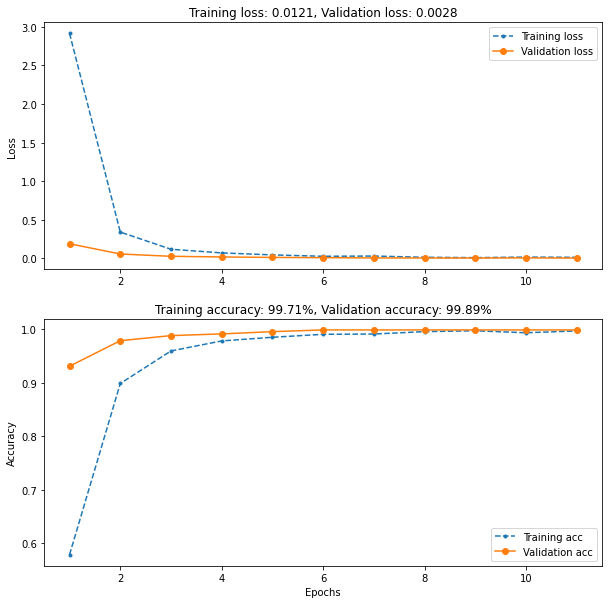

In [68]:
plot_loss_acc(history)

### c. Prédictions sur données de test

In [1]:
from tensorflow.keras import models
import numpy as np

In [12]:
final_model = models.load_model('models/vgg16_16_20_0.89.h5')

In [13]:
test_img, y_test = get_datasets(train=False, val=False, test=True)
class_labels, _ = get_labels()

Test:		Found 3568 images belonging to 5 classes.


In [15]:
y_predict = final_model.predict(test_img)

In [16]:
y_predict_binary = np.zeros_like(y_predict)
for index, y in enumerate(y_predict):
    y_predict_binary[index][np.argmax(y)] = 1

0.9022315080589294


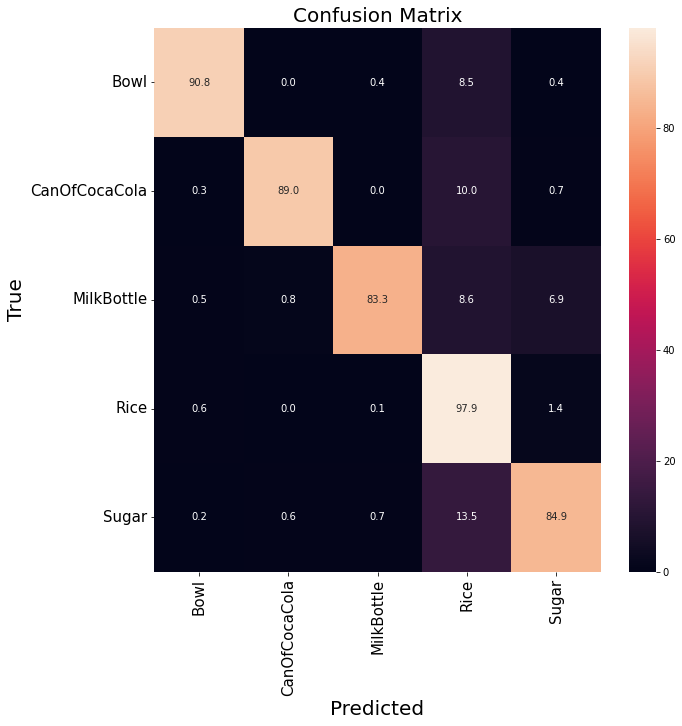

In [17]:
from sklearn.metrics import f1_score

print(f1_score(y_test, y_predict_binary, average="macro"))
plot_multiclass_heatmap(y_test, y_predict_binary, class_labels, figsize=(10,10))

**Commentaire** : on est plutôt satisfait car on a les plus hautes valeurs sur la diagonales, ce qui signifie que notre modèle a de bonnes prédictions. Cependant, d'autres valeurs autres que sur la diagonale sortent un peu du lot.
Par exemple, le sucre est détecté en temps que bouteille de lait dans 12.4% des cas, et le riz est détecté en tant que bouteille de lait dans 9,4% des cas.

In [5]:
final_model = models.load_model('models/vgg16_a__9.h5')

In [3]:
img_test = get_random_test_img(16)

In [6]:
prediction = final_model.predict(img_test)

Bowl 100.0 [1.0000000e+00 1.5093132e-24 1.1916353e-24 1.7610121e-20 3.5374454e-30]


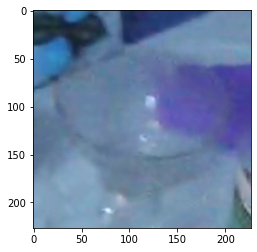

In [9]:
index = randint(0,len(img_test))
class_labels, _ = get_labels()
print(class_labels[np.argmax(prediction[index])], max(prediction[index])*100, prediction[index])
plt.imshow(img_test[index])

### d. Prédictions sur des images rdm

In [10]:
from tensorflow.keras import models
import numpy as np
from random import randint
import os
import random as rd
import cv2
import matplotlib.pyplot as plt
from skimage.transform import resize

final_model = models.load_model('models\weights-improvement-06-1.00.hdf5')

In [12]:
rdm_video_filename = "SugarPlace6Subject4.mp4"
rdm_video_path = os.path.join(path.__video_path__, rdm_video_filename)

list_bbox_filename = rdm_video_filename.split('.')[0] +"_2_bboxes.txt"
list_bbox_path = os.path.join(path.__bboxes_path__,list_bbox_filename)

num_first_frame_with_coord  = get_num_first_frame_with_coord(list_bbox_path)

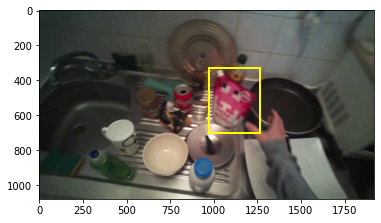

In [13]:
rdm_index_frame = 77
a_frame = get_frame_from_number(rdm_video_path, rdm_index_frame)
true_box = get_all_true_box(list_bbox_path)[rdm_index_frame]

plt.imshow(cv2.cvtColor(a_frame, cv2.COLOR_BGR2RGB))
plot_box(plt, rect=true_box)

rdm_boxes = generate_rdm_boxes_from_box([true_box[0], true_box[1], true_box[2], true_box[3]], 0.9, 0, a_frame.shape[1], a_frame.shape[0], 32)
rdm_img = [a_frame[box[1] : box[1] + box[3], box[0] : box[0] + box[2]] for box in rdm_boxes]
rdm_img_arr = np.array([cv2.resize(img, dsize=(227, 227)) for img in rdm_img])

In [14]:
prediction = final_model.predict(rdm_img_arr)

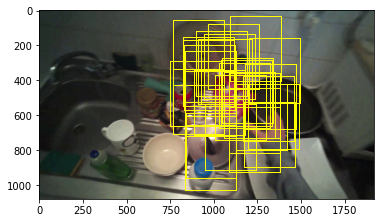

In [15]:
plt.imshow(cv2.cvtColor(a_frame, cv2.COLOR_BGR2RGB))
for i, box in enumerate(rdm_boxes):
    plot_box(plt, rect=(box[0],box[1],box[2],box[3]), linewidth=1)

C:\Users\paull\anaconda3\envs\3a_ia\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


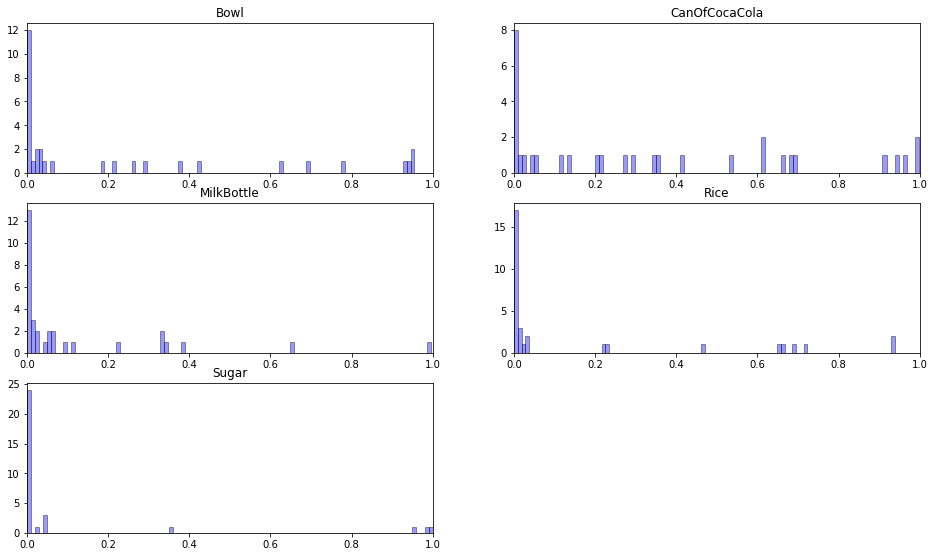

In [16]:
import seaborn as sns
class_labels, _ = get_labels()

plt.figure(figsize=(16,16))


proba = [0]*5
for i in range(len(class_labels)):
    proba[i] = [pr[i] for pr in prediction]


for i, label in enumerate(class_labels):
    plt.subplot(521+i)
    sns.distplot(proba[i], hist=True, kde=False, 
                bins=100, color = 'blue',
                hist_kws={'edgecolor':'black'})
    plt.xlim(0, 1)
    plt.title(label)

0.99798167 5.712377e-10


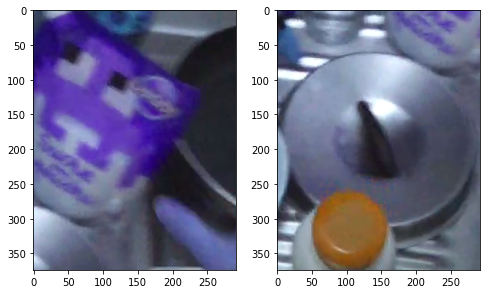

In [17]:
class_id = 4 
print(max(proba[1]), min(proba[class_id]))
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(rdm_img[np.argmax(proba[class_id])])
plt.subplot(122)
plt.imshow(rdm_img[np.argmin(proba[class_id])])